<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Assignment_4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

XXX By Mesay

XXX By Zilal

XXX By Jianci

# **Reference**
https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

# **Setting**

In [312]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [313]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [314]:
#change with your path
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/CA/'

Text(0, 0.5, 'Duration')

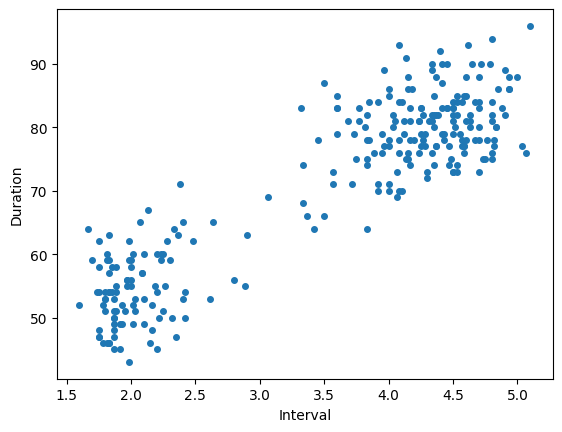

In [315]:
data = pd.read_table(path_to_data+"faithful.dat", sep="\s+", index_col=0)
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Interval')
plt.ylabel('Duration')

In [316]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


In [317]:
#create a matrix for all sample sizes for G, the corresponding p, u
def create_s_mtrx(G,n,s_interval=10): #sample size interval is default to 10, not required by instruction, but will need to handle G >2 as required by the instruction
  #matrix of G/ aka Z
  G_mtrx = np.arange(1,G+1,1)
  #sample size by group
  s_mtrx = s_interval*2**(G_mtrx-1)

  cumsum_s_mtrx =  np.cumsum(s_mtrx, axis =0)
  cumsum_s_mtrx

  #anything above limit taking 0s
  G_mtrx[cumsum_s_mtrx > n] = 0
  s_mtrx[cumsum_s_mtrx > n] = 0
  cumsum_s_mtrx[cumsum_s_mtrx > n] = 0
  #print(cumsum_s_mtrx)

  #biggest possible matrix
  max_G = np.where(cumsum_s_mtrx>0)[0][-1]+2

  final_G = min(max_G,G)
  last_s_mtrx = n - sum(s_mtrx[0:final_G-1])
  s_mtrx[final_G-1]=last_s_mtrx
  try:
    s_mtrx[final_G:]=0
  except:
    pass

  G_mtrx_final = np.arange(1,final_G+1,1)
  s_mtrx_final = s_mtrx[0:final_G]


  # initialize matrix of p
  p_mtrx = s_mtrx_final /n

  #create a new dim in data to show the G assignment
  G_assignment = np.repeat(G_mtrx_final,s_mtrx_final)
  p_assignment = np.repeat(p_mtrx,s_mtrx_final)

  #data with g assignment
  data_wg = data.copy()
  data_wg['G'] = G_assignment
  data_wg['p'] = p_assignment

  # calculate U by group for the two dimenison
  # keep column names so it's easier to understand
  mean_df = data_wg.groupby('G').mean().transpose()
  #u_by_k.columns = [ 'G','eruptions_avg',	'waiting_avg']

  return   G_mtrx_final, s_mtrx_final, p_mtrx, final_G, data_wg, mean_df


In [318]:
#number of componants
G=3
#sample size
n=len(data)

G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df= create_s_mtrx(G,n,s_interval=10)

In [319]:
G_mtrx

array([1, 2, 3])

In [320]:
s_mtrx

array([ 10,  20, 242])

In [321]:
p_mtrx

array([0.03676471, 0.07352941, 0.88970588])

In [322]:
data_wg

,eruptions,waiting,G,p
1,3.600,79,1,0.036765
2,1.800,54,1,0.036765
3,3.333,74,1,0.036765
4,2.283,62,1,0.036765
5,4.533,85,1,0.036765
...,...,...,...,...
268,4.117,81,3,0.889706
269,2.150,46,3,0.889706
270,4.417,90,3,0.889706
271,1.817,46,3,0.889706


In [323]:
data_mtrx = data[['eruptions','waiting']].to_numpy().reshape(-1,1)

In [324]:
data_wg_cal = data_wg.copy()

In [325]:
mean_df

G,1,2,3
eruptions,3.303200,3.175000,3.521260
waiting,71.800000,68.250000,71.078512
p,0.036765,0.073529,0.889706


In [326]:
mean_temp = mean_df.iloc[0:G].T
mean_temp

,eruptions,waiting,p
G,,,
1,3.30320,71.800000,0.036765
2,3.17500,68.250000,0.073529
3,3.52126,71.078512,0.889706


In [327]:
mean_temp['ug'] = [np.array(row) for row in mean_temp[['eruptions','waiting']].to_numpy()]
mean_temp

,eruptions,waiting,p,ug
G,,,,
1,3.30320,71.800000,0.036765,"[3.3032000000000004, 71.8]"
2,3.17500,68.250000,0.073529,"[3.175, 68.25]"
3,3.52126,71.078512,0.889706,"[3.5212603305785124, 71.07851239669421]"


In [328]:
mean_temp['ug'].to_numpy()

array([array([ 3.3032, 71.8   ]), array([ 3.175, 68.25 ]),
       array([ 3.52126033, 71.0785124 ])], dtype=object)

In [329]:
mean_mtrx_by_G = np.vstack(mean_temp['ug'].values)
mean_mtrx_by_G

array([[ 3.3032    , 71.8       ],
       [ 3.175     , 68.25      ],
       [ 3.52126033, 71.0785124 ]])

In [330]:
for i in range(0,final_G):
  print(mean_mtrx_by_G[i])

[ 3.3032 71.8   ]
[ 3.175 68.25 ]
[ 3.52126033 71.0785124 ]


In [331]:
mean_mtrx = np.array(mean_df)

In [332]:

data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - mean_mtrx[0]#average eruptions time
data_erp = pd.DataFrame(data_erp)
data_erp.columns= ['erp_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [333]:
data_erp

,erp_diff_1,erp_diff_2,erp_diff_3
0,0.2968,0.425,0.07874
1,-1.5032,-1.375,-1.72126
2,0.0298,0.158,-0.18826
3,-1.0202,-0.892,-1.23826
4,1.2298,1.358,1.01174
...,...,...,...
267,0.8138,0.942,0.59574
268,-1.1532,-1.025,-1.37126
269,1.1138,1.242,0.89574
270,-1.4862,-1.358,-1.70426


In [334]:
data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) -mean_mtrx[1]#average waiting time
data_wait = pd.DataFrame(data_wait)
data_wait.columns= ['wait_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [335]:
data_e_m = pd.DataFrame(mean_mtrx[0]).transpose()
data_e_m.columns= ['erp_'+ col for col in G_mtrx.astype('str').tolist()]

In [336]:
data_w_m = pd.DataFrame(mean_mtrx[1]).transpose()
data_w_m.columns= ['wait_'+ col for col in G_mtrx.astype('str').tolist()]

In [337]:
data_p = pd.DataFrame(mean_mtrx[2]).transpose()
data_p.columns= ['p_'+ col for col in G_mtrx.astype('str').tolist()]

In [338]:


data_wg_cal = data_wg_cal.merge(data_p, how='cross').merge(data_e_m,how='cross').merge(data_w_m,how='cross')
data_wg_cal = pd.concat([data_wg_cal,data_erp,data_wait],axis = 1)
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,p_3,erp_1,erp_2,erp_3,wait_1,wait_2,wait_3,erp_diff_1,erp_diff_2,erp_diff_3,wait_diff_1,wait_diff_2,wait_diff_3
0,3.600,79,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,0.2968,0.425,0.07874,7.2,10.75,7.921488
1,1.800,54,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,-1.5032,-1.375,-1.72126,-17.8,-14.25,-17.078512
2,3.333,74,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,0.0298,0.158,-0.18826,2.2,5.75,2.921488
3,2.283,62,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,-1.0202,-0.892,-1.23826,-9.8,-6.25,-9.078512
4,4.533,85,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,1.2298,1.358,1.01174,13.2,16.75,13.921488


In [339]:
data_wg_cal['erp_mean']=np.repeat(mean_mtrx[0],s_mtrx)
data_wg_cal['erp_diff']=data_wg_cal['eruptions']-data_wg_cal['erp_mean']
data_wg_cal['wait_mean']=np.repeat(mean_mtrx[1],s_mtrx)
data_wg_cal['wait_diff']=data_wg_cal['waiting']-data_wg_cal['wait_mean']

In [340]:
data_wg_cal['xi']= [np.reshape(np.array(row),(1,2)) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]
data_wg_cal['u']= [np.reshape(np.array(row),(1,2)) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]

In [341]:
data_wg_cal

,eruptions,waiting,G,p,p_1,p_2,p_3,erp_1,erp_2,erp_3,...,erp_diff_3,wait_diff_1,wait_diff_2,wait_diff_3,erp_mean,erp_diff,wait_mean,wait_diff,xi,u
0,3.600,79,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,0.07874,7.2,10.75,7.921488,3.30320,0.29680,71.800000,7.200000,"[[3.6, 79.0]]","[[3.3032000000000004, 71.8]]"
1,1.800,54,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-1.72126,-17.8,-14.25,-17.078512,3.30320,-1.50320,71.800000,-17.800000,"[[1.8, 54.0]]","[[3.3032000000000004, 71.8]]"
2,3.333,74,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-0.18826,2.2,5.75,2.921488,3.30320,0.02980,71.800000,2.200000,"[[3.333, 74.0]]","[[3.3032000000000004, 71.8]]"
3,2.283,62,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-1.23826,-9.8,-6.25,-9.078512,3.30320,-1.02020,71.800000,-9.800000,"[[2.283, 62.0]]","[[3.3032000000000004, 71.8]]"
4,4.533,85,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,1.01174,13.2,16.75,13.921488,3.30320,1.22980,71.800000,13.200000,"[[4.533, 85.0]]","[[3.3032000000000004, 71.8]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,4.117,81,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,0.59574,9.2,12.75,9.921488,3.52126,0.59574,71.078512,9.921488,"[[4.117, 81.0]]","[[3.5212603305785124, 71.07851239669421]]"
268,2.150,46,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-1.37126,-25.8,-22.25,-25.078512,3.52126,-1.37126,71.078512,-25.078512,"[[2.15, 46.0]]","[[3.5212603305785124, 71.07851239669421]]"
269,4.417,90,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,0.89574,18.2,21.75,18.921488,3.52126,0.89574,71.078512,18.921488,"[[4.417, 90.0]]","[[3.5212603305785124, 71.07851239669421]]"
270,1.817,46,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-1.70426,-25.8,-22.25,-25.078512,3.52126,-1.70426,71.078512,-25.078512,"[[1.817, 46.0]]","[[3.5212603305785124, 71.07851239669421]]"


In [342]:
data_wg_cal['xi_minus_u']= data_wg_cal['xi']-data_wg_cal['u']

In [343]:
data_wg_cal['xi_minus_u_T']= ([np.reshape(np.array(row),(2,1)) for row in data_wg_cal['xi']-data_wg_cal['u']])

In [344]:
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,p_3,erp_1,erp_2,erp_3,...,wait_diff_2,wait_diff_3,erp_mean,erp_diff,wait_mean,wait_diff,xi,u,xi_minus_u,xi_minus_u_T
0,3.600,79,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,10.75,7.921488,3.3032,0.2968,71.8,7.2,"[[3.6, 79.0]]","[[3.3032000000000004, 71.8]]","[[0.29679999999999973, 7.200000000000003]]","[[0.29679999999999973], [7.200000000000003]]"
1,1.800,54,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-14.25,-17.078512,3.3032,-1.5032,71.8,-17.8,"[[1.8, 54.0]]","[[3.3032000000000004, 71.8]]","[[-1.5032000000000003, -17.799999999999997]]","[[-1.5032000000000003], [-17.799999999999997]]"
2,3.333,74,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,5.75,2.921488,3.3032,0.0298,71.8,2.2,"[[3.333, 74.0]]","[[3.3032000000000004, 71.8]]","[[0.029799999999999827, 2.200000000000003]]","[[0.029799999999999827], [2.200000000000003]]"
3,2.283,62,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-6.25,-9.078512,3.3032,-1.0202,71.8,-9.8,"[[2.283, 62.0]]","[[3.3032000000000004, 71.8]]","[[-1.0202000000000004, -9.799999999999997]]","[[-1.0202000000000004], [-9.799999999999997]]"
4,4.533,85,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,16.75,13.921488,3.3032,1.2298,71.8,13.2,"[[4.533, 85.0]]","[[3.3032000000000004, 71.8]]","[[1.2298, 13.200000000000003]]","[[1.2298], [13.200000000000003]]"


In [345]:

 #CA4,instruction p2, after 'Testing'
sigma = (data_wg_cal['xi_minus_u']*data_wg_cal['xi_minus_u_T']).sum(axis = 0)/n
sigma

array([[  1.28849554,  13.8662627 ],
       [ 13.8662627 , 183.56933185]])

In [346]:
# find determinant of sigma |sigma|
sigma_det = np.linalg.det(sigma)
sigma_det

44.25502506980155

E-Step
https://campuswire.com/c/GB46E5679/feed/589

In [347]:
data_wg_cal['xi_minus_u_T']

,xi_minus_u_T
0,"[[0.29679999999999973], [7.200000000000003]]"
1,"[[-1.5032000000000003], [-17.799999999999997]]"
2,"[[0.029799999999999827], [2.200000000000003]]"
3,"[[-1.0202000000000004], [-9.799999999999997]]"
4,"[[1.2298], [13.200000000000003]]"
...,...
267,"[[0.5957396694214876], [9.921487603305792]]"
268,"[[-1.3712603305785125], [-25.078512396694208]]"
269,"[[0.8957396694214874], [18.921487603305792]]"
270,"[[-1.7042603305785125], [-25.078512396694208]]"


In [348]:
data_wg_cal['eruptions']

,eruptions
0,3.600
1,1.800
2,3.333
3,2.283
4,4.533
...,...
267,4.117
268,2.150
269,4.417
270,1.817


In [349]:
#(np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0]).T*sigma**2*(np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0])

In [350]:
data_wg_cal=data_wg_cal.reset_index()
data_wg_cal

,index,eruptions,waiting,G,p,p_1,p_2,p_3,erp_1,erp_2,...,wait_diff_2,wait_diff_3,erp_mean,erp_diff,wait_mean,wait_diff,xi,u,xi_minus_u,xi_minus_u_T
0,0,3.600,79,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,...,10.75,7.921488,3.30320,0.29680,71.800000,7.200000,"[[3.6, 79.0]]","[[3.3032000000000004, 71.8]]","[[0.29679999999999973, 7.200000000000003]]","[[0.29679999999999973], [7.200000000000003]]"
1,1,1.800,54,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,...,-14.25,-17.078512,3.30320,-1.50320,71.800000,-17.800000,"[[1.8, 54.0]]","[[3.3032000000000004, 71.8]]","[[-1.5032000000000003, -17.799999999999997]]","[[-1.5032000000000003], [-17.799999999999997]]"
2,2,3.333,74,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,...,5.75,2.921488,3.30320,0.02980,71.800000,2.200000,"[[3.333, 74.0]]","[[3.3032000000000004, 71.8]]","[[0.029799999999999827, 2.200000000000003]]","[[0.029799999999999827], [2.200000000000003]]"
3,3,2.283,62,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,...,-6.25,-9.078512,3.30320,-1.02020,71.800000,-9.800000,"[[2.283, 62.0]]","[[3.3032000000000004, 71.8]]","[[-1.0202000000000004, -9.799999999999997]]","[[-1.0202000000000004], [-9.799999999999997]]"
4,4,4.533,85,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,...,16.75,13.921488,3.30320,1.22980,71.800000,13.200000,"[[4.533, 85.0]]","[[3.3032000000000004, 71.8]]","[[1.2298, 13.200000000000003]]","[[1.2298], [13.200000000000003]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,267,4.117,81,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,...,12.75,9.921488,3.52126,0.59574,71.078512,9.921488,"[[4.117, 81.0]]","[[3.5212603305785124, 71.07851239669421]]","[[0.5957396694214876, 9.921487603305792]]","[[0.5957396694214876], [9.921487603305792]]"
268,268,2.150,46,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,...,-22.25,-25.078512,3.52126,-1.37126,71.078512,-25.078512,"[[2.15, 46.0]]","[[3.5212603305785124, 71.07851239669421]]","[[-1.3712603305785125, -25.078512396694208]]","[[-1.3712603305785125], [-25.078512396694208]]"
269,269,4.417,90,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,...,21.75,18.921488,3.52126,0.89574,71.078512,18.921488,"[[4.417, 90.0]]","[[3.5212603305785124, 71.07851239669421]]","[[0.8957396694214874, 18.921487603305792]]","[[0.8957396694214874], [18.921487603305792]]"
270,270,1.817,46,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,...,-22.25,-25.078512,3.52126,-1.70426,71.078512,-25.078512,"[[1.817, 46.0]]","[[3.5212603305785124, 71.07851239669421]]","[[-1.7042603305785125, -25.078512396694208]]","[[-1.7042603305785125], [-25.078512396694208]]"


# **E-STEP**

In [351]:
#approach II

In [352]:
sigma_inv = np.linalg.inv(sigma)

In [353]:
mean_df.T.reset_index()

,G,eruptions,waiting,p
0,1,3.30320,71.800000,0.036765
1,2,3.17500,68.250000,0.073529
2,3,3.52126,71.078512,0.889706


In [354]:
mean_df.T

,eruptions,waiting,p
G,,,
1,3.30320,71.800000,0.036765
2,3.17500,68.250000,0.073529
3,3.52126,71.078512,0.889706


In [355]:
mean_mtrx_by_G = mean_df.T.reset_index().to_numpy()
mean_mtrx_by_G

array([[1.00000000e+00, 3.30320000e+00, 7.18000000e+01, 3.67647059e-02],
       [2.00000000e+00, 3.17500000e+00, 6.82500000e+01, 7.35294118e-02],
       [3.00000000e+00, 3.52126033e+00, 7.10785124e+01, 8.89705882e-01]])

In [358]:
#mean_mtrx_by_G_rep

In [359]:
xi_rep = np.tile(data_wg_cal[['index','eruptions','waiting']].to_numpy(), (G,1) )

In [360]:
xi_rep

array([[  0.   ,   3.6  ,  79.   ],
       [  1.   ,   1.8  ,  54.   ],
       [  2.   ,   3.333,  74.   ],
       ...,
       [269.   ,   4.417,  90.   ],
       [270.   ,   1.817,  46.   ],
       [271.   ,   4.467,  74.   ]])

In [361]:
mean_mtrx_by_G_rep[:,1:3]

array([[ 3.3032    , 71.8       ],
       [ 3.3032    , 71.8       ],
       [ 3.3032    , 71.8       ],
       ...,
       [ 3.49482824, 70.86259542],
       [ 3.49482824, 70.86259542],
       [ 3.49482824, 70.86259542]])

In [362]:
x_mean = (xi_rep[:,1:3] - mean_mtrx_by_G_rep[:,1:3])

ValueError: operands could not be broadcast together with shapes (816,2) (544,2) 

In [ ]:
df_x_mean = pd.DataFrame(x_mean)
df_x_mean['index']=xi_rep[:,0:1]
df_x_mean['G']=mean_mtrx_by_G_rep[:,0:1]
df_x_mean['P']=mean_mtrx_by_G_rep[:,3:4]
df_x_mean.columns= ['eruptions','waiting','index','G','P']

In [ ]:
df_x_mean

In [ ]:
df_x_mean_pivot = pd.pivot(df_x_mean, index='G', columns='index')
df_x_mean_pivot

In [ ]:
df_x_mean_pivot[:,:]

In [ ]:
mean_temp = mean_df.iloc[0:G].T
mean_temp

In [ ]:
A = data_wg_cal[['eruptions','waiting']].to_numpy()
A.shape

In [ ]:
B = mean_temp.to_numpy()
B.shape

In [ ]:
A-B

In [ ]:
A_minus_u = data_wg_cal['xi']-data_wg_cal['u']
A_minus_u

# use SVD to decompose sigma

# approach I

In [363]:
#use SVD to decompose sigma
#approach I

U, S, UT = np.linalg.svd(sigma)

In [383]:
sigma

array([[  1.28849554,  13.8662627 ],
       [ 13.8662627 , 183.56933185]])

In [364]:
U

array([[-0.07542027, -0.99715184],
       [-0.99715184,  0.07542027]])

In [365]:
S

array([184.61811623,   0.23971117])

In [366]:
np.diag(S)

array([[184.61811623,   0.        ],
       [  0.        ,   0.23971117]])

In [367]:
UT

array([[-0.07542027, -0.99715184],
       [-0.99715184,  0.07542027]])

In [368]:
#double check
U @ np.diag(S) @ UT

array([[  1.28849554,  13.8662627 ],
       [ 13.8662627 , 183.56933185]])

In [369]:
4**0.5

2.0

In [370]:
D_tilde = np.diag(1/(S**0.5))
D_tilde

array([[0.07359746, 0.        ],
       [0.        , 2.04247083]])

In [371]:
sigma_inv = U @ (D_tilde**2) @ UT
sigma_inv

array([[ 4.14798843, -0.31332629],
       [-0.31332629,  0.02911524]])

In [372]:
#double check
np.linalg.inv(sigma)

array([[ 4.14798843, -0.31332629],
       [-0.31332629,  0.02911524]])

In [373]:
D_tilde

array([[0.07359746, 0.        ],
       [0.        , 2.04247083]])

In [374]:
data_wg_cal[['eruptions','waiting']].to_numpy()

array([[ 3.6  , 79.   ],
       [ 1.8  , 54.   ],
       [ 3.333, 74.   ],
       [ 2.283, 62.   ],
       [ 4.533, 85.   ],
       [ 2.883, 55.   ],
       [ 4.7  , 88.   ],
       [ 3.6  , 85.   ],
       [ 1.95 , 51.   ],
       [ 4.35 , 85.   ],
       [ 1.833, 54.   ],
       [ 3.917, 84.   ],
       [ 4.2  , 78.   ],
       [ 1.75 , 47.   ],
       [ 4.7  , 83.   ],
       [ 2.167, 52.   ],
       [ 1.75 , 62.   ],
       [ 4.8  , 84.   ],
       [ 1.6  , 52.   ],
       [ 4.25 , 79.   ],
       [ 1.8  , 51.   ],
       [ 1.75 , 47.   ],
       [ 3.45 , 78.   ],
       [ 3.067, 69.   ],
       [ 4.533, 74.   ],
       [ 3.6  , 83.   ],
       [ 1.967, 55.   ],
       [ 4.083, 76.   ],
       [ 3.85 , 78.   ],
       [ 4.433, 79.   ],
       [ 4.3  , 73.   ],
       [ 4.467, 77.   ],
       [ 3.367, 66.   ],
       [ 4.033, 80.   ],
       [ 3.833, 74.   ],
       [ 2.017, 52.   ],
       [ 1.867, 48.   ],
       [ 4.833, 80.   ],
       [ 1.833, 59.   ],
       [ 4.783, 90.   ],


In [375]:
A = D_tilde @ UT

In [376]:
A

array([[-0.00555074, -0.07338785],
       [-2.03665353,  0.1540437 ]])

In [377]:
B = data_wg_cal[['eruptions','waiting']].to_numpy()

In [378]:
B.shape

(272, 2)

In [379]:
A.shape

(2, 2)

In [380]:
#IS THIS CORRECT (IF NOT TRANSPOSE)- ValueError: shapes (2, 2) and (272, 2) not aligned
xi_tilde = D_tilde @ UT @ data_wg_cal[['eruptions','waiting']].T
xi_tilde

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
0,-5.817622,-3.972935,-5.449201,-4.562719,-6.263128,-4.052334,-6.484219,-6.257949,-3.753604,-6.262113,...,-4.266764,-6.114782,-3.166684,-4.415760,-5.530454,-5.967268,-3.387775,-6.629424,-3.385927,-5.455496
1,4.837500,4.652383,4.611068,4.901029,3.861564,2.600731,3.983574,5.761762,3.884754,4.234272,...,5.166726,4.129850,2.585195,4.660151,1.879173,4.092637,2.707205,4.868034,3.385411,2.301502


In [382]:
mean_mtrx_by_G

array([[1.00000000e+00, 3.30320000e+00, 7.18000000e+01, 3.67647059e-02],
       [2.00000000e+00, 3.17500000e+00, 6.82500000e+01, 7.35294118e-02],
       [3.00000000e+00, 3.52126033e+00, 7.10785124e+01, 8.89705882e-01]])

In [381]:
uk_tilde = D_tilde @ UT @ mean_mtrx_by_G[:,1:3]
uk_tilde

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [ ]:
D_tilde @ UT @ data_wg_cal[['eruptions','waiting']].to_numpy().T


In [ ]:
chk = (np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0])

In [ ]:
[np.reshape(np.array(row),(1,2)) for row in chk]

In [ ]:
(np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0])

In [ ]:
data_wg_cal['xi']- mean_mtrx_by_G[i]

In [ ]:
np.array(data_wg_cal['xi_minus_ug_T'])*(sigma**-1)*data_wg_cal['xi_minus_ug']

In [ ]:
#create the term for loglik function
data_wg_cal['loglik_term'] = data_wg_cal['p']*(np.exp(-0.5*data_wg_cal['xi_minus_ug_T']*(sigma**-1)*data_wg_cal['xi_minus_ug']))

In [ ]:
#marginal likely hoold function
m_col = data_wg_cal.columns.tolist()
m_col
erp_diff_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('erp_diff_')]]
erp_diff_G_mtrx.head()


In [ ]:
wait_diff_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('wait_diff_')]]
wait_diff_G_mtrx.head()

In [ ]:
p_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('p_')]]
p_G_mtrx.head()

In [ ]:
sigma

In [ ]:
sigma**-1

In [ ]:
a = np.array(data_wg_cal[['erp_diff_'+i,'wait_diff_'+i]])

In [ ]:
np.dot((sigma**-1),a.T)

In [ ]:
for i in G_mtrx:
  #print(i)
  i = (i).astype('str')
  #print(ci)
  np.numpy(data_wg_cal[['erp_diff_'+i,'wait_diff_'+i]])
  mlf = data_wg_cal['p_'+i]*np.exp(-0.5*())
  print(mlf.head())

In [ ]:
mlf

In [ ]:
[itm2+itm1 for itm1 in G_mtrx.astype('str').tolist() for itm2 in ['p_','erp_diff_','wait_diff_']]

In [ ]:
['erp_diff_','wait_diff_']+'1'

In [ ]:
'erp_diff_'+G_mtrx.astype('str').tolist()

In [ ]:
G_mtrx = data_wg_cal[[c for c in m_col if c.endswith('erp_diff_')]]
erp_diff_G_mtrx

In [ ]:
#initialize p1:pn
#for the G = 2 case, start with assuming 10 samples from G1, which will
#result in p1-hat = 10/n

p1 = s_interval/n
p1

In [ ]:
p2 = 1-p1
p2

In [ ]:
u1 = np.mean(data,axis = 0)
u1

In [ ]:
#initialize a matrix for p with 0s, output required for E-step
p_mtrx = np.zeros((n,G))
p_mtrx.shape

Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.


Mstep function: This function should return the updated parameters for the Gaussian mixture model.


loglik function: This function computes the log-likelihood of the data given the parameters.

myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function)

# **Part II: HMM**

Baum-Welch Algorihtm

Viterbi Algorihtm

# **================ CODE ARCHIVE ================================**

In [ ]:
# TEST PANDA WITH MATRIX
matrix_1 = pd.DataFrame([[1, 2], [3, 4]])

In [ ]:
matrix_1

In [ ]:
# TEST PANDA WITH MATRIX
matrix_2 = pd.DataFrame([[[1,2],[3, 4]], [[5, 6],[7,8]]])

In [ ]:
matrix_2

In [ ]:
matrix_3 = pd.DataFrame([[np.zeros((2,3))], [np.zeros((3,2))]])
matrix_3

In [ ]:
data_wg_cal.head()

In [ ]:
data_wg_cal['x_i']= [np.array(row) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]

In [ ]:
data_wg_cal['u_g']= [np.array(row) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]

In [ ]:
data_wg_cal

In [ ]:
data_wg_cal['x_i'] - data_wg_cal['u_g']

In [ ]:

#silly way to calculate sigma - result match
# [a,b] * [a,b].T is bascially a^2 +ab+ab+ b^2
#data_wg_cal[['eruptions_2',	'waiting_2']] = data_wg_cal[[	'eruptions',	'waiting']]**2
#data_wg_cal[['erp_mean_2',	'wait_mean_2']] = data_wg_cal[[	'erp_mean',	'wait_mean']]**2
#data_wg_cal['eruptions_erp_mean'] = data_wg_cal['eruptions']*data_wg_cal['erp_mean']
#data_wg_cal['waiting_wait_mean'] = data_wg_cal['waiting']*data_wg_cal['wait_mean']
data_wg_cal[['erp_diff_2',	'wait_diff_2']]  = data_wg_cal[[	'erp_diff',	'wait_diff']]**2
data_wg_cal['erp_wait_diff']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']
data_wg_cal['erp_wait_diff_again']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']

#CA4,instruction p2, after 'Testing'
sigma = np.array(data_wg_cal[['erp_diff_2','erp_wait_diff','erp_wait_diff_again','wait_diff_2']].mean()).reshape(2,2)
sigma

In [ ]:
#manually check the determinant function
#det(A)=ad−bc
sigma_det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
sigma_det